### Setup notebook 

In [1]:
# Utility libraries
from itertools import repeat
import json
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import pdfplumber
import statistics
import string
import time
import tqdm

# Graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP libraries
import torch
import transformers
from transformers import pipeline, AutoTokenizer

# Custom libraries
import my_utility as utility

### Load annotations

N = number of documents

In [2]:
# Insert path of file with answers, Haystack format
# Change accordingly to your PC paths
my_path = '/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/'
all_annotations = [my_path+f for f in listdir(my_path) if isfile(join(my_path, f))]
all_annotations = sorted(all_annotations)

### Setup pipeline

M = number of questions

In [3]:
# Model from HuggingFace
# model_checkpoint = 'luigisaetta/squad_it_xxl_cased_hub1'
# model_checkpoint = 'mrm8488/bert-italian-finedtuned-squadv1-it-alfa'
model_checkpoint = 'deepset/xlm-roberta-large-squad2'

In [4]:
# Setup QA pipeline
nlp = pipeline(
    'question-answering',
    model=model_checkpoint,
    tokenizer=model_checkpoint,
    max_anwer_len = 30,
    handle_impossible_answer = True # Only for squad2 models
)

In [5]:
# Get questions
all_questions = []
counter = 0
data, paragraph = utility.get_annotations_data(all_annotations[0]) # Read first annotation file, to get list of questions

In [6]:
for i, (k, v) in enumerate(data[0].items()):
    if (k.startswith('question') and not k.endswith('ID')):
        all_questions.append((counter, v))
        counter+=1
        
my_questions = all_questions

In [6]:
# Optional: remove question (e.g. sex related questions, since they require inference)
# my_questions.pop(2)
# my_questions.pop(2)

In [7]:
# Create list of predicted answers
pred_answers = [[] for i in repeat(None, len(all_annotations))]

### Get answers

In [8]:
start = time.time()
for j, file in enumerate(all_annotations):
    print(file)
    data, paragraph = utility.get_annotations_data(file)
    for doc in data:
        for i, q in my_questions:
            # print(q)
            # print(doc['context'])
            QA_input = {
                'question': q,
                'context': doc['context']
            }
            pred_answers[j].append((i, nlp(QA_input)))
end = time.time()

/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/Doc_001.json
/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/Doc_002.json
/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/Doc_003.json
/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/Doc_004.json
/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/Doc_005.json
/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/Doc_006.json
/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/Doc_007.json
/home/claudio/ClaudioCrema_stuff/HBD/hbd-information-extraction/Annotations/HBD_cardiac_discharge_letters/Doc_008.json


In [9]:
print(f'Total time = {end-start:.2f} s')

Total time = 1307.30 s


In [10]:
pred_ans_for_stats = [[] for i in repeat(None, len(all_annotations))]
correct_ans_for_stats = [[] for i in repeat(None, len(all_annotations))]
for k, file in enumerate(all_annotations):
    counter = 0
    data, paragraph = utility.get_annotations_data(file)
    for j, doc in enumerate(data):    
        # print(f'****************** CONTEXT #{j} ******************\n')
        # print(f'{doc["context"]}')
        # PREDICTED ANSWERS
        for i, q in my_questions:
            pred_ans_for_stats[k].append(pred_answers[k][counter][1]["answer"].lower().strip(string.punctuation+' ').strip('\n'))
            correct_ans_for_stats[k].append(doc[f"answer_{i}"].lower().strip(string.punctuation+' '))
            counter+=1

In [11]:
# Compare correct answer with predicted one
for i, (ref_list, pred_list) in enumerate(zip(correct_ans_for_stats, pred_ans_for_stats)):
    print('#'*100)
    print(f'Doc {all_annotations[i].split("/")[-1]}')
    for j, (ref, pred) in enumerate(zip(ref_list, pred_list)):
        print('-'*50)
        print(f'Question {my_questions[j][0]}: {my_questions[j][1]}')
        print(f'Reference answer = "{ref}"')
        print(f'Predicted answer = "{pred}"')

####################################################################################################
Doc Doc_001.json
--------------------------------------------------
Question 0: Qual è l'anno di nascita?
Reference answer = ""
Predicted answer = ""
--------------------------------------------------
Question 1: Qual è l'anno di nascita del paziente?
Reference answer = ""
Predicted answer = ""
--------------------------------------------------
Question 2: Qual è l'età?
Reference answer = "65"
Predicted answer = "65"
--------------------------------------------------
Question 3: Qual è l'età del paziente?
Reference answer = "65"
Predicted answer = "65"
--------------------------------------------------
Question 4: Quanto è alto?
Reference answer = ""
Predicted answer = ""
--------------------------------------------------
Question 5: Quanto è alto il paziente?
Reference answer = ""
Predicted answer = "anni 65"
--------------------------------------------------
Question 6: Quato pesa?
Re

### Elaborate results

In [146]:
# Calculate EM Scores
EM_scores = [[] for i in repeat(None, len(all_annotations))]
EM_score_not_emptys = [[] for i in repeat(None, len(all_annotations))]
EM_score_emptys = [[] for i in repeat(None, len(all_annotations))]
for i, (correct_answers, pred_answers) in enumerate(zip(correct_ans_for_stats, pred_ans_for_stats)):
    EM_scores[i], EM_score_not_emptys[i] = utility.get_EM_score(correct_answers, pred_answers)

In [147]:
# Calculate FPs, FNs, TPs
# all_TP/FP/FN_global are N x M lists
all_TP_global = [[] for i in repeat(None, len(all_annotations))]
all_FP_global = [[] for i in repeat(None, len(all_annotations))]
all_FN_global = [[] for i in repeat(None, len(all_annotations))]
for i, (correct_answers, pred_answers) in enumerate(zip(correct_ans_for_stats, pred_ans_for_stats)):
    all_TP_global[i], all_FP_global[i], all_FN_global[i] = utility.get_all_quest_param(correct_answers, pred_answers, model_checkpoint)

In [148]:
F1_global = [[] for i in repeat(None, len(all_annotations))]
for i, (doc_TP, doc_FP, doc_FN) in enumerate(zip(all_TP_global, all_FP_global, all_FN_global)):
    temp_FP = []
    for j, (TP, FP, FN) in enumerate(zip(doc_TP, doc_FP, doc_FN)):
        P, R, F1 = utility.calculate_stat_param(TP, FP, FN)
        temp_FP.append(F1)
        F1_global[i] = temp_FP

#### Global

In [149]:
EM_TOTAL = statistics.mean(EM_scores)
EM_NOT_EMPTY_TOTAL = statistics.mean(EM_score_not_emptys) # 
full_TP = sum([sum(i) for i in zip(*all_TP_global)])
full_FP = sum([sum(i) for i in zip(*all_FP_global)])
full_FN = sum([sum(i) for i in zip(*all_FN_global)])
F1_MACRO_TOTAL = statistics.mean([item for sublist in F1_global for item in sublist])
P_TOTAL, R_TOTAL, F1_WEIGHTED_TOTAL = utility.calculate_stat_param(full_TP, full_FP, full_FN)

print(f'GLOBAL EM = {EM_TOTAL*100:.2f}%')
print(f'GLOBAL EM (NOT EMPTY ANSWERS) = {EM_NOT_EMPTY_TOTAL*100:.2f}%')
print(f'GLOBAL P = {P_TOTAL*100:.2f}%')
print(f'GLOBAL R = {R_TOTAL*100:.2f}%')
print(f'GLOBAL F1 WEIGHTED = {F1_WEIGHTED_TOTAL*100:.2f}%') # Starting from global TPs, FPs, FNs
print(f'GLOBAL F1 MACRO = {F1_MACRO_TOTAL*100:.2f}%') # Average of F1s on single queestions

GLOBAL EM = 67.36%
GLOBAL EM (NOT EMPTY ANSWERS) = 31.87%
GLOBAL P = 46.20%
GLOBAL R = 20.17%
GLOBAL F1 WEIGHTED = 28.08%
GLOBAL F1 MACRO = 12.80%


#### By single question (sq)

In [150]:
index = []
for i, q in my_questions:
    index.append(f'Q{i}')

In [151]:
# Single question F1 scores
sq_TPs = [0] * len(my_questions)
sq_FPs = [0] * len(my_questions)
sq_FNs = [0] * len(my_questions)
quest_num = len(my_questions)

for i, stats in enumerate(zip(all_TP_global, all_FP_global, all_FN_global)):
    tp, fp, fn = stats[0], stats[1], stats[2]
    for j in range(quest_num):
        sq_TPs[j]+=tp[j]
        sq_FPs[j]+=fp[j]
        sq_FNs[j]+=fn[j]

In [152]:
# Single question EM scores
EM_scores_single = [[] for i in repeat(None, len(all_annotations))]
for i, (correct_answers, pred_answers) in enumerate(zip(correct_ans_for_stats, pred_ans_for_stats)):
    EM_scores_single[i] = utility.get_EM_score_single_questions(correct_answers, pred_answers)

In [153]:
# Create DataFrame with scores for single questions on all documents
df_questions = pd.DataFrame(
    index=index,
    columns=['Precision', 'Recall', 'F1-score', 'EM']
)

In [154]:
counter = 0
for i, q in my_questions:
    # print(i, q)
    P, R, F1 = utility.calculate_stat_param(sq_TPs[counter], sq_FPs[counter], sq_FNs[counter])
    # print(P, R, F1)
    EM_ith_question = [x[counter] for x in EM_scores_single]
    try:
        df_questions.loc[f'Q{i}', 'Precision']=f'{P*100:.2f}'
    except:
        df_questions.loc[f'Q{i}', 'Precision']='0'
    try:
        df_questions.loc[f'Q{i}', 'Recall']=f'{R*100:.2f}'
    except:
        df_questions.loc[f'Q{i}', 'Recall']='0'
    try:
        df_questions.loc[f'Q{i}', 'F1-score']=f'{F1*100:.2f}'
    except:
        df_questions.loc[f'Q{i}', 'F1-score']='0'
    try:
        df_questions.loc[f'Q{i}', 'EM']=statistics.mean(EM_ith_question)*100
    except:
        pass
    counter+=1
df_questions = df_questions.apply(pd.to_numeric)

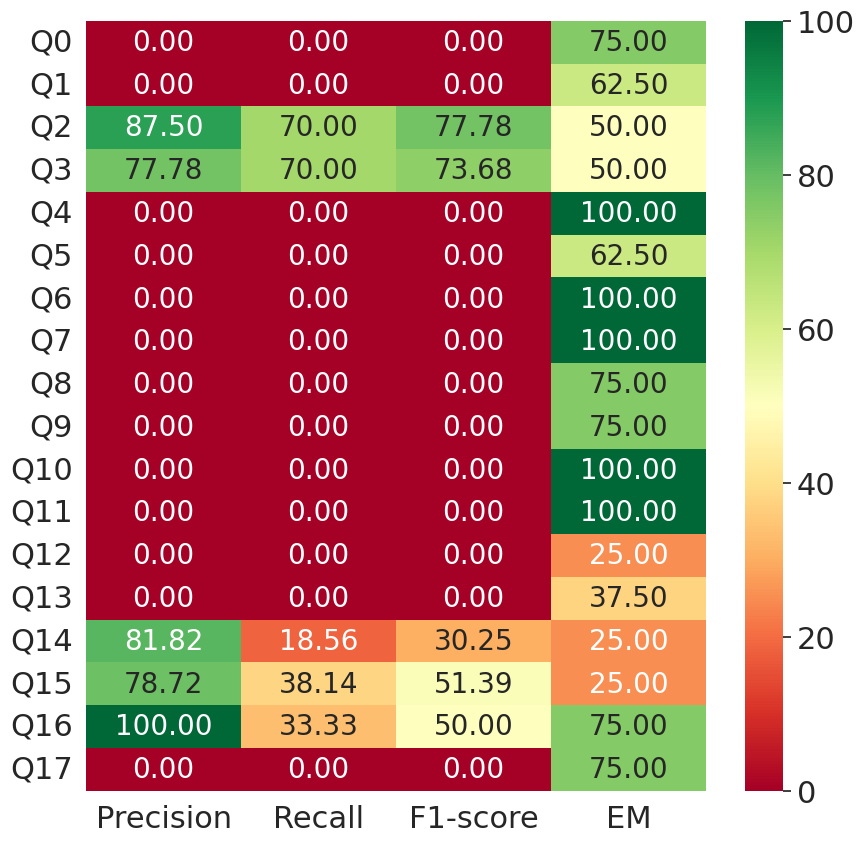

In [155]:
# Convert dataframe to heatmap, by questions
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_questions, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=100)
fig.savefig(f'QUESTIONS_heat.png', dpi=400, transparent=True, bbox_inches='tight')

#### By single document (sd)

In [156]:
index = []
for i, q in enumerate(all_annotations):
    index.append(f'DOC{i}')

In [157]:
# Single document F1 scores
sd_TPs = [0] * len(all_annotations)
sd_FPs = [0] * len(all_annotations)
sd_FNs = [0] * len(all_annotations)
doc_num = len(all_annotations)

In [158]:
for i, stats in enumerate(zip(all_TP_global, all_FP_global, all_FN_global)):
    tp, fp, fn = stats[0], stats[1], stats[2]
#     print(tp, fp, fn)
    sd_TPs[i]+=sum(tp)
    sd_FPs[i]+=sum(fp)
    sd_FNs[i]+=sum(fn)

In [159]:
# Single document EM scores
EM_scores_single = [[] for i in repeat(None, len(all_annotations))]
for i, (correct_answers, pred_answers) in enumerate(zip(correct_ans_for_stats, pred_ans_for_stats)):
    EM_scores_single[i] = utility.get_EM_score_single_questions(correct_answers, pred_answers)

In [160]:
# Create DataFrame with scores for single questions on all documents
df_documents = pd.DataFrame(
    index=index,
    columns=['Precision', 'Recall', 'F1-score', 'EM']
)

In [161]:
counter = 0
for i, doc in enumerate(all_annotations):
    # print(i, doc)
    P, R, F1 = utility.calculate_stat_param(sd_TPs[counter], sd_FPs[counter], sd_FNs[counter])
#     print(P, R, F1)
    EM_ith_question = [x[counter] for x in EM_scores_single]
    try:
        df_documents.loc[f'DOC{i}', 'Precision']=f'{P*100:.2f}'
    except:
        df_documents.loc[f'DOC{i}', 'Precision']='0'
    try:
        df_documents.loc[f'DOC{i}', 'Recall']=f'{R*100:.2f}'
    except:
        df_documents.loc[f'DOC{i}', 'Recall']='0'
    try:
        df_documents.loc[f'DOC{i}', 'F1-score']=f'{F1*100:.2f}'
    except:
        df_documents.loc[f'DOC{i}', 'F1-score']='0'
    try:
        df_documents.loc[f'DOC{i}', 'EM']=statistics.mean(EM_ith_question)*100
    except:
        pass
    counter+=1
df_documents = df_documents.apply(pd.to_numeric)

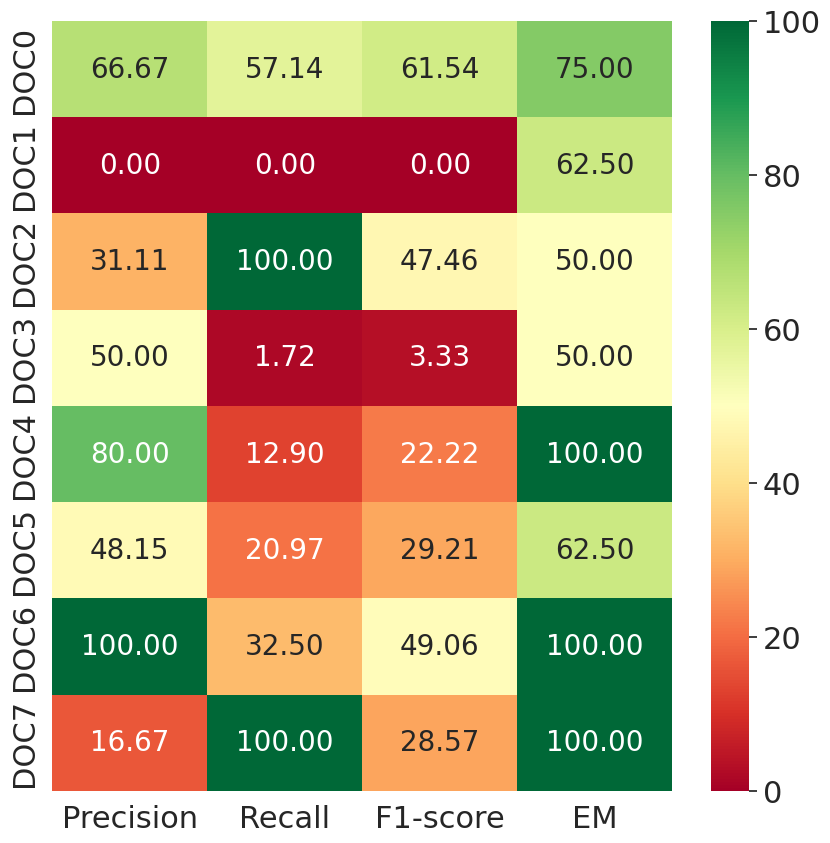

In [162]:
# Convert dataframe to heatmap, by questions
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_documents, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=100)
fig.savefig(f'DOCUMENTS_heat.png', dpi=400, transparent=True, bbox_inches='tight')

# New code
Code from this point is to implement and test

### Plot and interpolate

In [163]:
# import scipy as sp
# from scipy.interpolate import interp1d

In [164]:
# def log_interp1d(xx, yy, kind='linear'):
#     logx = np.log10(xx)
#     logy = np.log10(yy)
#     lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
#     log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
#     return log_interp

In [165]:
# # Sort Dataframe
# df_documents =  df_documents.sort_values(by='Doc lenght')

In [166]:
# x = np.array(df_documents['Doc lenght'].tolist())
# y = np.array(df_documents['F1-score'].tolist())

In [167]:
# # f = interp1d(x, y)
# # f2 = interp1d(x, y, kind='quadratic')
# f2 = log_interp1d(x, y)

In [168]:
# xnew = np.arange(x[0], x[-1], (x[-1]-x[0])/100)

In [169]:
# fig, ax = plt.subplots(figsize=(10,10))
# # plt.plot(x, y, 'o', xnew, f2(xnew), '--')
# plt.plot(x, y, 'o', xnew, f2(xnew), '--')
# plt.legend(['data', 'interp'], loc='best')
# plt.show()

### Elaborate global results

In [170]:
# total_TP = sum(all_TP)
# total_FP = sum(all_FP)
# total_FN = sum(all_FN)

# total_precision = total_TP/(total_TP+total_FP)
# total_recall = total_TP/(total_TP+total_FN)
# total_f1 = 2*total_precision*total_recall/(total_precision+total_recall)

# print(f'Total Precision = {total_precision*100:.2f}%')
# print(f'Total Recall = {total_recall*100:.2f}%')
# print(f'Total F1-score = {total_f1*100:.2f}%')

### Calculate BLEU score

In [171]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [172]:
ref_corpus_bleu = [[i.split()] for i in correct_ans_for_stats]
pred_corpus_bleu = [i.split() for i in pred_ans_for_stats]

AttributeError: 'list' object has no attribute 'split'

In [ ]:
correct_ans_for_stats[0][0]

In [ ]:
pred_ans_for_stats[0][0]

In [ ]:
reference = [[
    'this is a dog'.split(),
    'it is dog'.split(),
    'dog it is'.split(),
    'a dog, it is'.split() 
]]
reference

In [ ]:
candidate = ['it is dog'.split()]
candidate

In [ ]:
# BLEU score of all answers
# score = corpus_bleu(ref_corpus_bleu, pred_corpus_bleu)
# score = sentence_bleu(reference, candidate)
score = corpus_bleu(reference, candidate)
print(f'Total BLEU score = {score}')

In [ ]:
import nltk
hypothesis = ['This', 'is', 'cat'] 
reference = ['This', 'is', 'a', 'cat']
references = [reference] # list of references for 1 sentence.
list_of_references = [references] # list of references for all sentences in corpus.
list_of_hypotheses = [hypothesis] # list of hypotheses that corresponds to list of references.
nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)

In [ ]:
# Reference answers, divided by question
ref_corpus_bleu_Q1 = [[i.split()] for j, i in enumerate(correct_ans_for_stats) if j%5==0]
ref_corpus_bleu_Q2 = [[i.split()] for j, i in enumerate(correct_ans_for_stats) if (j-1)%5==0]
ref_corpus_bleu_Q3 = [[i.split()] for j, i in enumerate(correct_ans_for_stats) if (j-2)%5==0]
ref_corpus_bleu_Q4 = [[i.split()] for j, i in enumerate(correct_ans_for_stats) if (j-3)%5==0]
ref_corpus_bleu_Q5 = [[i.split()] for j, i in enumerate(correct_ans_for_stats) if (j-4)%5==0]
ref_corpus_TOT = [ref_corpus_bleu_Q1, ref_corpus_bleu_Q2, ref_corpus_bleu_Q3, ref_corpus_bleu_Q4, ref_corpus_bleu_Q5]

# Predicted answers, divided by question
pred_corpus_bleu_Q1 = [i.split() for j, i in enumerate(pred_ans_for_stats) if j%5==0]
pred_corpus_bleu_Q2 = [i.split() for j, i in enumerate(pred_ans_for_stats) if (j-1)%5==0]
pred_corpus_bleu_Q3 = [i.split() for j, i in enumerate(pred_ans_for_stats) if (j-2)%5==0]
pred_corpus_bleu_Q4 = [i.split() for j, i in enumerate(pred_ans_for_stats) if (j-3)%5==0]
pred_corpus_bleu_Q5 = [i.split() for j, i in enumerate(pred_ans_for_stats) if (j-4)%5==0]
pred_corpus_TOT = [pred_corpus_bleu_Q1, pred_corpus_bleu_Q2, pred_corpus_bleu_Q3, pred_corpus_bleu_Q4, pred_corpus_bleu_Q5]

In [ ]:
# for j, (ref, pred) in enumerate(zip(ref_corpus_TOT, pred_corpus_TOT)):
#     score = corpus_bleu(ref, pred)
#     print(f'Total BLEU score = {score:.3f} for Question {j+1}')

In [ ]:
# scores = []
# for target, prediction in zip(correct_ans_for_stats, pred_ans_for_stats):
#     print('^'*50)
#     print(f'Reference = "{target}"')
#     print(f'Prediction = "{prediction}"')
#     print(f'BLEU SCORE = {sentence_bleu([target], prediction):.3f}')
#     scores.append(sentence_bleu([target], prediction))

In [ ]:
# model_checkpoint = 'deepset/roberta-base-squad2' # SQUAD2 multilangual model

In [ ]:
# # Made-up context, short, translated with Google translate
# my_context = '''70-year-old male patient. Examination performed urgently, in basal conditions.
# In the depth of the white matter in the right temporo-parietal site we can appreciate furnishing
# roughly roundish of about 2 cm surrounded by an imposing edema reaction.
# Another more minute hypodense area of the white matter seems to be appreciated in the frontal seat since.
# There is currently no evidence of intracranial bleeding.
# Median structure in axis.
# Ventricular complex of normal amplitude and morphology.
# An in-depth diagnostic study could be appropriate, possibly confirming with an MRI examination
# Therefore the patient resigns with the following advice:
# - Keppra 500 1 tablet twice a day;
# - Soldesam 4 mg 1 fl im per day for 15 days; then deltacortene 25 mg 1 tablet twice a day for 5 days; subsequently 1 tablet per day for a further 5 days;
# - Antra 20 mg 1 tablet / day for 20 days;
# - Brain MRI in 30 days and subsequent neurological re-evaluation to decide on a further treatment plan.'''

In [ ]:
# # Made-up context, long, translated with Google translate
# my_context = '''Dear colleague, your client resigns on: 16.06.2015

# with the following diagnosis:
# DIASTOLIC CARDIAC INSUFFICIENCY WITH DILATATION OF THE DX SECTIONS IN FA IN TAO IN LABYLE COMPENSATION (CONGESTIZIO DISOMPENSATION = EDEMI OF CONSPICIOUS LOWER LIMBS)) WITH PULMONARY HYPERTENSION. ULCERS FROM INFECTED LOWER LIMBS PHLEBOSTASIS (PSEUDOMONAS AERUGINOSA). SEVERAL RIGHT GONARTHROSIS SUBJECTED TO ARTHROCENTHESIS. TYPE 2 DIABETES MELLITUS REWARDED AND COMPLICATED BY NEPHROPATHY. CHRONIC KIDNEY INSUFFICIENCY REGREDITY.
 
# Anamnestic news:
# Non-smoking patient, suffering from arterial hypertension, type 2 diabetes mellitus, permanent atrial fibrillation in NAO. Denies allergies. Following the onset of hyperpyrexia unresponsive to antibiotic polytherapy (clarithromycin, piperacillin / tazobactam) and progressive pain in the right knee limiting walking, she arrives in the emergency room where she performs a radiogram examination of the right knee and orthopedic examination which, due to a suspected septic arthritis, recommends hospitalization in an internist setting for evaluations and appropriate treatments.

# Abnormal blood tests on discharge:
# Glycosylated Hb 8.2; GFR: 85ml / min; Creatinine: 0.7mg; BUN: 23.0mg, pro-BNP: 3139.0; Microalbuminuria 60.5; Sodium 132 -> 135; blood sugar 210 -> 41; Sideremia 42; Alkaline phosphatase 110; LDH 233; Hb 12.5; pro-BNP 5103; Albumin 38.9; Alpha-1-globulins 7,1; Alpha-2-globulins 14.8; Beta-2-globulins 6,7; Gamma-globulins 44.3; ESR 52; PCR: 5.18, e.g. right skin ulcer swab: Positive for Ciprofloxacin sensitive Pseudomonas; ex. biological liquid: 35200 cells, Cell. prevalence of polymormonucleated, LDH: 1330.0, Prot.Tot: 5.00, ex. cultural: neg.
   

# Instrumental examinations:
# RX OF THE CHEST - RX OF THE RIGHT KNEE (4/06/2015): Marked tricompartmental gonarthrosis phenomena on the right. Marked swelling of the soft tissues of the right knee, particularly evident in the supra-patellar site as due to the presence of an effusion in the sub-quadriceps synovial recess. Diffuse irregular femoro-popliteal-tibio-peroneal vascular calcifications. Osteopenia. The examination of the thorax does not show pulmonary consolidations in the act of inflammatory significance or pleural effusion flaps. Enlarged cardiac image. Signs of stagnation in the small circle. Aorta ectatic and calcific.
# ELECTROCARDIOGRAM (5/06/2015): Atrial fibrillation at 82 bpm; BBDx almost complete. Partially secondary anomalies of ventricular repolarization.
# RHEUMATOLOGICAL EXAMINATION (7/06/2015): About 8 days ago onset of fever and right knee arthralgia with joint swelling. No joint pain at rest. Not fever at present. OE: signs of joint effusion of the right knee, non rubor, functional limitation of the right knee joint, slight edema of the right leg. Recent right leg ulcer infection. In anticoagulant therapy. Conclusion: probable right knee hemarthrosis in severe gonarthrosis. We recommend: ice pack for 20 minutes for 2 vv / day. Rest of the lower limbs. Monitor PCR, protein electrophoresis every 5 days. ETG knee.
# ECHOCARDIOGRAM (10/06/2015): Examination performed in the patient's bed, not very cooperative. With these limitations we document: Ritmo da F.A. Slightly hypertrophic left ventricle (septal thickness 11.4 mm), not dilated, with global contractile function at the lower limits of the norm (EF about 50%). Bi-atrial dilations, greater on the right. Mild to moderate mitral regurgitation. Mild aortic regurgitation, in sclerotic valve. Right ventricle dilated and slightly hypokinetic (TAPSE 17 mm). Moderate-severe IT with PAPs estimated at 25 mmHg + 15 mmHg. VCI dilated and hypocollassing (27/20 mm).

# Observations / Therapies carried out:
# During the hospital stay, the patient underwent arthrocentesis (17.0718) of the right knee with sampling of synovial fluid; subjected to empirical antibiotic therapy first and then targeted (ATB) we witnessed a regression of the fever and clinical improvement and skin ulcers of the lower limbs; also subjected to t. diuretic and iv edema of the lower limbs almost regressed.

# Home treatment and indications:
# HYPOSODIC AND HYPOCALORIC DIET
#     • Eucreas 50 mg / 1000 mg 1 tablet for 2 vv / day
#     • Baypress 20 mg - 1 tablet / day
#     • Eliquis 2.5 1 cp for 2 vv / day
#     • Carvedilol 6.25 mg - 1 tablet / day
#     • Lasix 25 mg - 1 tablet for 2 vv / day
#     • Luvion 50 mg - 1 tablet / day
#     • Ciproxin 500 mg - 1 tablet for 2 vv / day for 10 days
#     • Lower limb skin dressing right with phytostimolines


# Also perform:
#     • Kidney function, protein electrophoresis, PCR in about 5-7 days
#     • Cons. Rheumatology + ETG right knee in 15 days

# Periodically check blood pressure, body weight, kidney and liver function tests, blood counts.'''

In [ ]:
# my_questions = [
#                 'What is the pathological condition?',
#                 'What is the age?',
#                 'What is the sex?',
#                 'What medications he takes?',
#                 'What are the surgical procedures to which he is subjected?',
# ]

In [ ]:
# # a) Get predictions
# nlp = pipeline('question-answering', model=model_checkpoint, tokenizer=model_checkpoint)

In [ ]:
# my_answers = []

# for q in my_questions:
#   QA_input = {
#       'question': q,
#       'context': my_context
#   }
#   my_answers.append(nlp(QA_input))

In [ ]:
# print(f'****************** CONTEXT ******************\n{my_context}')
# for i, (q, ans) in enumerate(zip((my_questions), my_answers)):
#   print('*'*50)
#   print(f'QUESTION INDEX {i+1}= "{q}"')
#   print(f'ANSWER = "{ans["answer"]}"')
#   print(f'ANSWER SCORE = {ans["score"]*100:.2f}%')